<a href="https://colab.research.google.com/github/ntolayd/Projects/blob/main/Recommendation_Engines/Rec_Eng_Deep_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/ml-1m.zip"

Archive:  /content/gdrive/My Drive/ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
movies = pd.read_csv("ml-1m/movies.dat", sep='::', engine='python', header=None)
movies.columns = ['movie_id', 'movie_name', 'genre']
ratings = pd.read_csv("ml-1m/ratings.dat", sep='::', engine='python', header=None)
ratings.columns=['user_id', 'movie_id', 'rating','timestamp']

In [ ]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
movies.head()

,movie_id,movie_name,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
final_df = ratings.merge(movies, how='left', left_on='movie_id', right_on='movie_id')

In [ ]:
final_df.isna().sum()

user_id       0
movie_id      0
rating        0
timestamp     0
movie_name    0
genre         0
dtype: int64

Base Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Concatenate, Dropout
from keras.layers.merge import Multiply
from keras.layers.merge import Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(final_df, test_size=0.1, random_state=123)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_set['genre_encoded']=encoder.fit_transform(train_set['genre'])
test_set['genre_encoded'] = encoder.transform(test_set['genre'])

In [ ]:
unique_movie_numb = final_df['movie_id'].max()
unique_user_numb = final_df['user_id'].max()
unique_genre_numb= final_df['genre'].nunique()

In [ ]:
embedding_size= 5

#Movie input
input_movies = Input(shape=[1])
embed_movies = Embedding(unique_movie_numb + 1,embedding_size,name = 'movie_embedding')(input_movies)
movies_out = Flatten()(embed_movies)

#user network
input_users = Input(shape=[1])
embed_users = Embedding(unique_user_numb + 1,embedding_size,name = 'user_embedding')(input_users)
users_out = Flatten()(embed_users)

y = Dot(1, normalize=False)([users_out, movies_out])

model = Model(inputs=[input_users, input_movies], outputs=y)

model.compile(loss='mse',
              optimizer=Adam(lr=0.001),
              metrics=['mae']
             )

In [ ]:
history = model.fit([train_set["user_id"], train_set["movie_id"]]
                    , train_set["rating"]
                    , batch_size=64, epochs=10
                    , validation_split=0.1
                    , shuffle=True)


Epoch 1/10
12659/12659 [==============================] - 19s 1ms/step - loss: 9.3250 - mae: 2.6793 - val_loss: 1.1647 - val_mae: 0.8384
Epoch 2/10
12659/12659 [==============================] - 18s 1ms/step - loss: 1.0277 - mae: 0.7914 - val_loss: 0.8879 - val_mae: 0.7412
Epoch 3/10
12659/12659 [==============================] - 18s 1ms/step - loss: 0.8672 - mae: 0.7334 - val_loss: 0.8656 - val_mae: 0.7329
Epoch 4/10
12659/12659 [==============================] - 18s 1ms/step - loss: 0.8520 - mae: 0.7280 - val_loss: 0.8603 - val_mae: 0.7316
Epoch 5/10
12659/12659 [==============================] - 18s 1ms/step - loss: 0.8449 - mae: 0.7248 - val_loss: 0.8523 - val_mae: 0.7279
Epoch 6/10
12659/12659 [==============================] - 18s 1ms/step - loss: 0.8320 - mae: 0.7198 - val_loss: 0.8406 - val_mae: 0.7223
Epoch 7/10
12659/12659 [==============================] - 19s 1ms/step - loss: 0.8178 - mae: 0.7132 - val_loss: 0.8244 - val_mae: 0.7151
Epoch 8/10
12659/12659 [=================

Deeper model

In [ ]:
embedding_size= 10

#Movie input
input_movies = Input(shape=[1])
embed_movies = Embedding(unique_movie_numb + 1,embedding_size,name = 'movie_embedding')(input_movies)
movies_out = Flatten()(embed_movies)

#user input
input_users = Input(shape=[1])
embed_users = Embedding(unique_user_numb + 1,embedding_size,name = 'user_embedding')(input_users)
users_out = Flatten()(embed_users)


input_vecs = Concatenate()([users_out, movies_out])


x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.2)(x)


y = Dense(1)(x)

model = Model(inputs=[input_users, input_movies], outputs=y)

model.compile(loss='mse',
              optimizer=Adam(lr=0.001),
              metrics=['mae']
             )

In [ ]:
history = model.fit([train_set["user_id"], train_set["movie_id"]]
                    , train_set["rating"]
                    , batch_size=64, epochs=10
                    , validation_split=0.1
                    , shuffle=True)


Epoch 1/10
12659/12659 [==============================] - 30s 2ms/step - loss: 1.3684 - mae: 0.8754 - val_loss: 0.8244 - val_mae: 0.7165
Epoch 2/10
12659/12659 [==============================] - 29s 2ms/step - loss: 0.8314 - mae: 0.7208 - val_loss: 0.8051 - val_mae: 0.7024
Epoch 3/10
12659/12659 [==============================] - 29s 2ms/step - loss: 0.7931 - mae: 0.7028 - val_loss: 0.7885 - val_mae: 0.7005
Epoch 4/10
12659/12659 [==============================] - 30s 2ms/step - loss: 0.7726 - mae: 0.6922 - val_loss: 0.7802 - val_mae: 0.6975
Epoch 5/10
12659/12659 [==============================] - 31s 2ms/step - loss: 0.7555 - mae: 0.6838 - val_loss: 0.7757 - val_mae: 0.6933
Epoch 6/10
12659/12659 [==============================] - 30s 2ms/step - loss: 0.7456 - mae: 0.6785 - val_loss: 0.7727 - val_mae: 0.6890
Epoch 7/10
12659/12659 [==============================] - 29s 2ms/step - loss: 0.7371 - mae: 0.6740 - val_loss: 0.7773 - val_mae: 0.6982
Epoch 8/10
12659/12659 [=================

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
preds = model.predict([test_set["user_id"], test_set["movie_id"]])
print(mean_absolute_error(test_set['rating'], preds))
print(math.sqrt(mean_squared_error(test_set['rating'], preds)))

0.6896369240722826
0.8776536872924331


In [ ]:
#visualize embeddings
# Extract embeddings
movie_em = model.get_layer('movie_embedding')
movie_em_weights = movie_em.get_weights()[0]

In [ ]:
movie_em_weights.shape

(3953, 10)

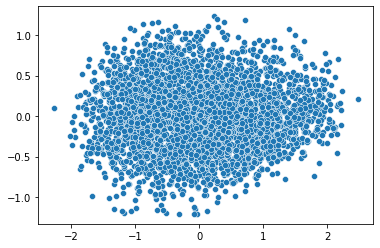

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
pca_result = pca.fit_transform(movie_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3953 samples in 0.006s...
[t-SNE] Computed neighbors for 3953 samples in 0.310s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3953
[t-SNE] Computed conditional probabilities for sample 2000 / 3953
[t-SNE] Computed conditional probabilities for sample 3000 / 3953
[t-SNE] Computed conditional probabilities for sample 3953 / 3953
[t-SNE] Mean sigma: 0.126430
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.530746
[t-SNE] KL divergence after 1000 iterations: 1.621066


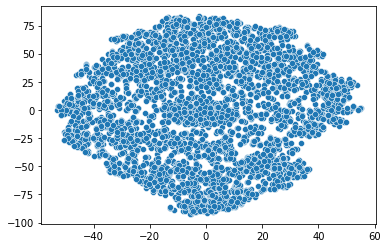

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30)
tnse_results = tsne.fit_transform(movie_em_weights)
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

Making Recommendations

In [ ]:
movie_ids = np.array(list(set(ratings['movie_id'])))
#for user 123
user = np.array([123 for i in range(len(movie_ids))])
genre = np.array([1 for i in range(len(movie_ids))])
predictions = model.predict([user, movie_ids])
predictions = np.array([a[0] for a in predictions])
recommended_movie_ids = (-predictions).argsort()[:10]

In [ ]:
#movies already watched by user 123
final_df[final_df['user_id']==123].sort_values(by='rating', ascending=False)[:10][['user_id','rating','movie_name','genre']]

,user_id,rating,movie_name,genre
15695,123,5,Rain Man (1988),Drama
15301,123,5,Heat (1995),Action|Crime|Thriller
15711,123,5,Forrest Gump (1994),Comedy|Romance|War
15307,123,5,"Deer Hunter, The (1978)",Drama|War
15310,123,5,"Time to Kill, A (1996)",Drama
15312,123,5,One Flew Over the Cuckoo's Nest (1975),Drama
15324,123,5,"Silence of the Lambs, The (1991)",Drama|Thriller
15524,123,5,Braveheart (1995),Action|Drama|War
15504,123,5,Bottle Rocket (1996),Comedy
15841,123,5,True Romance (1993),Action|Crime|Romance


In [ ]:
#movies recommended to user 123
movies[movies['movie_id'].isin(recommended_movie_ids)]

,movie_id,movie_name,genre
48,49,When Night Is Falling (1995),Drama|Romance
250,253,Interview with the Vampire (1994),Drama|Horror
306,309,"Red Firecracker, Green Firecracker (1994)",Drama
509,513,Radioland Murders (1994),Comedy|Mystery|Romance
792,802,Phenomenon (1996),Drama|Romance
832,843,Lotto Land (1995),Drama
1052,1066,Shall We Dance? (1937),Comedy|Musical|Romance
1092,1108,Prerokbe Ognja (1995),Documentary
2240,2309,"Inheritors, The (Die Siebtelbauern) (1998)",Drama
2629,2698,Zone 39 (1997),Sci-Fi
